In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import load_img, img_to_array
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, BatchNormalization, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, classification_report

In [3]:
# Configuration
DATA_DIR = '/kaggle/input/severstal-steel-defect-detection'
TRAIN_IMAGE_DIR = os.path.join(DATA_DIR, 'train_images')
TEST_IMAGE_DIR = os.path.join(DATA_DIR, 'test_images')
MASK_CSV_PATH = os.path.join(DATA_DIR, 'train.csv')
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 25

In [5]:
# Load and inspect data
print("Loading CSV file...")
df = pd.read_csv(MASK_CSV_PATH)
print(f"Total entries: {len(df)}")

Loading CSV file...
Total entries: 7095


In [6]:

# Process labels
print("\nProcessing labels...")
image_class_df = df.groupby('ImageId')['ClassId'].apply(lambda x: list(set(x))).reset_index()
image_class_df['Labels'] = image_class_df['ClassId'].apply(
    lambda classes: [1 if (i+1) in classes else 0 for i in range(4)]
)


Processing labels...


In [7]:
# Load images and labels
print("\nLoading images and labels...")
images = []
labels = []

for _, row in tqdm(image_class_df.iterrows(), total=len(image_class_df)):
    img_id = row['ImageId']
    img_path = os.path.join(TRAIN_IMAGE_DIR, img_id)
    img = load_img(img_path, target_size=IMG_SIZE)
    images.append(img_to_array(img)/255.0)
    labels.append(row['Labels'])

X = np.array(images)
y = np.array(labels)
print(f"\nDataset shape - Images: {X.shape}, Labels: {y.shape}")


Loading images and labels...


100%|█████████████████████████████████████████████████████████████████████████████| 6666/6666 [00:30<00:00, 219.10it/s]



Dataset shape - Images: (6666, 224, 224, 3), Labels: (6666, 4)


In [8]:
# Train-test split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Training samples: {len(X_train)}, Validation samples: {len(X_val)}")

Training samples: 5332, Validation samples: 1334


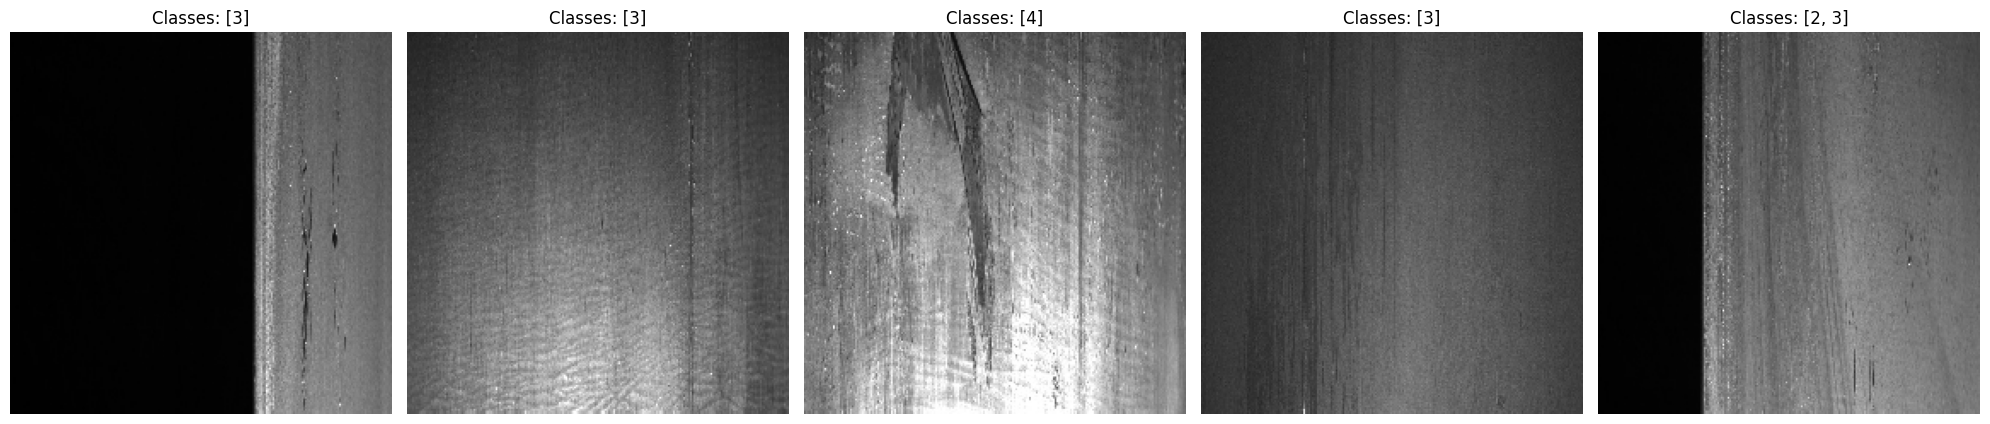

In [9]:
# Visualize samples
def plot_samples(images, labels, n=5):
    plt.figure(figsize=(20, 10))
    for i in range(n):
        plt.subplot(1, n, i+1)
        plt.imshow(images[i])
        class_labels = [j+1 for j, val in enumerate(labels[i]) if val == 1]
        plt.title(f"Classes: {class_labels}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

plot_samples(X_train[:5], y_train[:5])

In [10]:
# Detect multiple GPUs
strategy = tf.distribute.MirroredStrategy()

print(f"Number of GPUs: {strategy.num_replicas_in_sync}")

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)
Number of GPUs: 1


In [11]:
with strategy.scope():
    # Input layer
    inputs = Input(shape=(224, 224, 3))

    # Convolutional layers
    conv_1 = Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same')(inputs)
    maxp_1 = MaxPooling2D(pool_size=(2, 2))(conv_1)

    conv_2 = Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same')(maxp_1)
    maxp_2 = MaxPooling2D(pool_size=(2, 2))(conv_2)

    conv_3 = Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same')(maxp_2)
    maxp_3 = MaxPooling2D(pool_size=(2, 2))(conv_3)

    conv_4 = Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same')(maxp_3)
    maxp_4 = MaxPooling2D(pool_size=(2, 2))(conv_4)

    conv_5 = Conv2D(512, kernel_size=(3, 3), activation='relu', padding='same')(maxp_4)
    maxp_5 = MaxPooling2D(pool_size=(2, 2))(conv_5)

    # Flatten layer
    flatten = Flatten()(maxp_5)

    # Fully connected layers with dropout for regularization
    dense = Dense(512, activation='relu')(flatten)
    dropout = Dropout(0.1)(dense)

    # Output layer
    output = Dense(4, activation='sigmoid')(dropout)

    # Create model
    model = Model(inputs=inputs, outputs=output)

    # Compile model
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='binary_crossentropy',
                  metrics=['accuracy',
                           tf.keras.metrics.Precision(name='precision'),
                           tf.keras.metrics.Recall(name='recall')])

In [12]:
# Prepare datasets using tf.data API
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
val_dataset = val_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [13]:
# Callbacks and compilation
callbacks = [
    ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_loss'),
    EarlyStopping(patience=5, restore_best_weights=True, monitor='val_loss'),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3)
]

In [ ]:
# Train the model using the tf.data.Dataset objects
history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=val_dataset,
    callbacks=callbacks
)


Epoch 1/25
 92/167 ━━━━━━━━━━━━━━━━━━━━ 54s 722ms/step - accuracy: 0.7384 - loss: 0.3786 - precision: 0.7459 - recall: 0.7197